# Study of the Supervised Descent Method in Face Alignement

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import random
import pickle

# Import modules
from src.get_data import get_data
from src.model import SDM
from sklearn.linear_model import LinearRegression,Ridge

## Dataset analysis

The first step in order to train the model is to create a training dataset, which will be constitued of picture of faces with a target landmark.


For this we use the `get_data` function, it returns train and test sets of instances of the Image class, each instance of image gets a true landmark that is used for learning or computing error.

For training landmarks are initiated at a mean face shape at the center of a box found by the haar cascade face finder model.

In [ ]:
path_afw = r"data\ibug_300W_large_face_landmark_dataset\afw" 
path_lpfw=r"data\ibug_300W_large_face_landmark_dataset\lfpw\trainset"

DATA_PATH=path_lpfw

t0 = time.time()
train_data, test_data, mean_shape = get_data(DATA_PATH, train_split=0.8)
random.shuffle(train_data)
train_data=train_data[:2000]

print(f"Loaded data in {time.time()-t0:.2f} seconds.")
print(f"Number of train pictures : {len(train_data)}")
print(f"Number of test pictures : {len(test_data)}")

Data Cleaning: Kept 798 images. Rejected 13 bad detections.
Data loaded: 638 Train, 160 Test.
Generating augmented training data (10 per image)
Loaded data in 68.32 seconds.
Number of train pictures : 2000
Number of test pictures : 160


## SDM Model



### Training


In [ ]:
# Parameters

n_step=5
model=Ridge(alpha=1000) # LinearRegression()

In [ ]:
# Fitting

sdm=SDM(n_step=n_step,model=model)
t0 = time.time()
sdm.fit(train_data)
print(f"Finished training in {time.time()-t0:.2f} seconds.")

Training SDM on 2000 images for 5 steps.
Step 1 done.
Step 2 done.
Step 3 done.
Step 4 done.
Step 5 done.
Entraînement terminé en 753.86 secondes.


In [ ]:
# Save model
save=False

sauvegarde = {
    "model": model,          
    "mean_shape": mean_shape}

if save:
    with open("sdm_model.pkl", "wb") as f:
        pickle.dump(sauvegarde, f)

### Visualization

Test in image 89


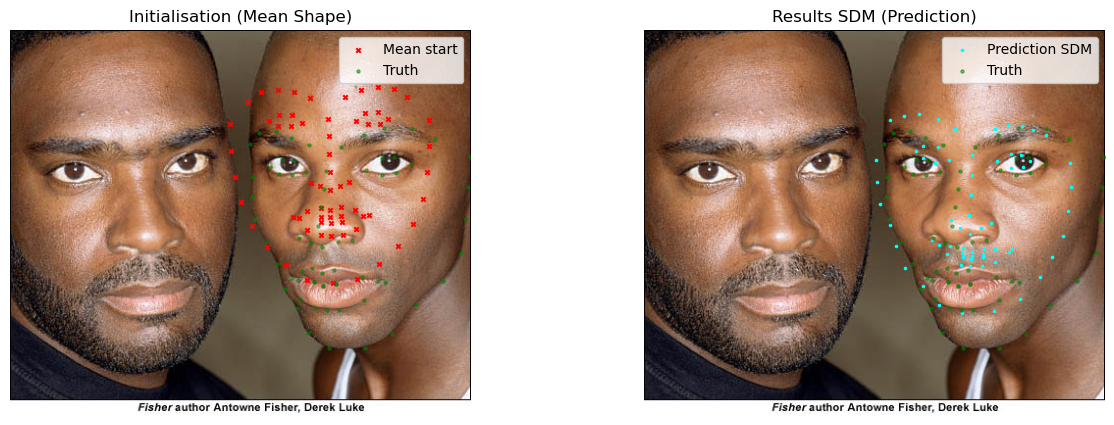

Test in image 22


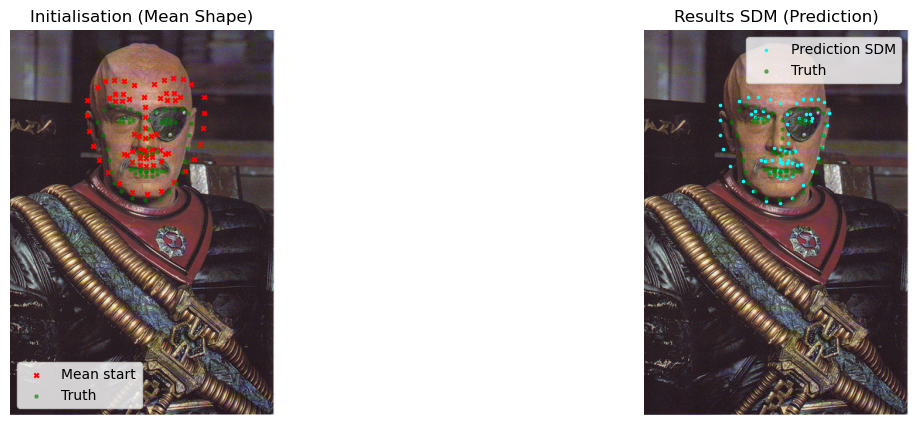

Test in image 15


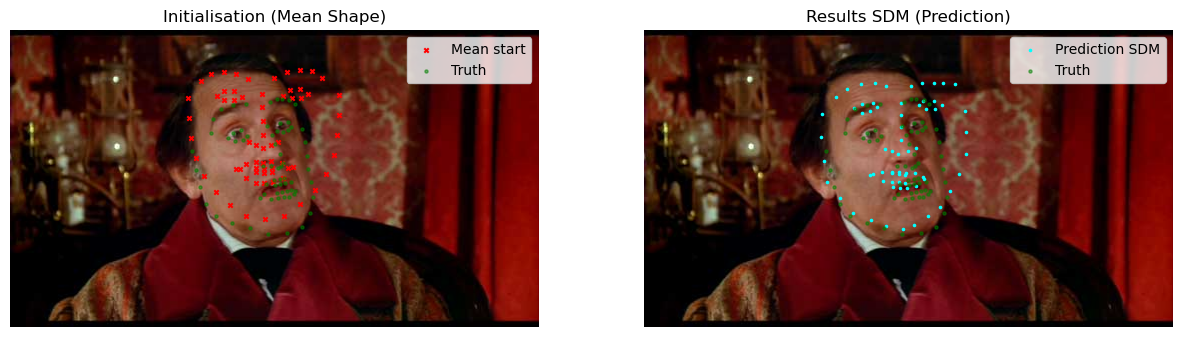

Test in image 118


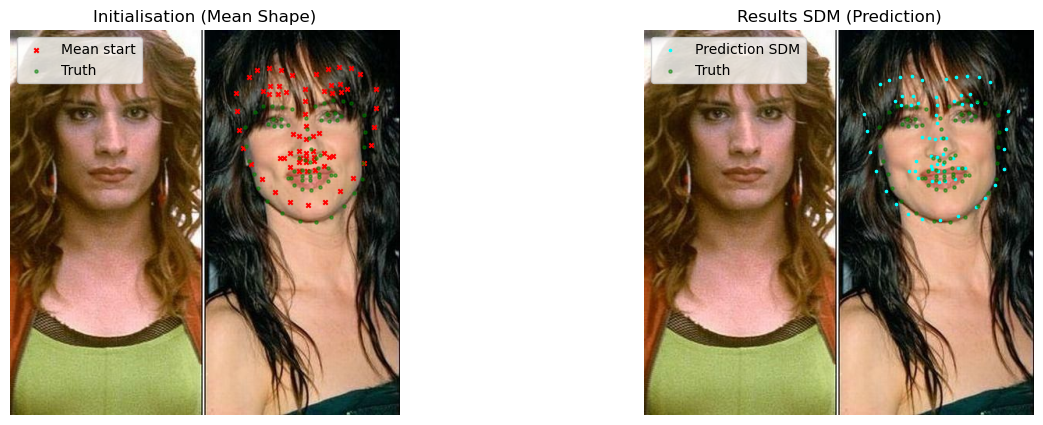

Test in image 25


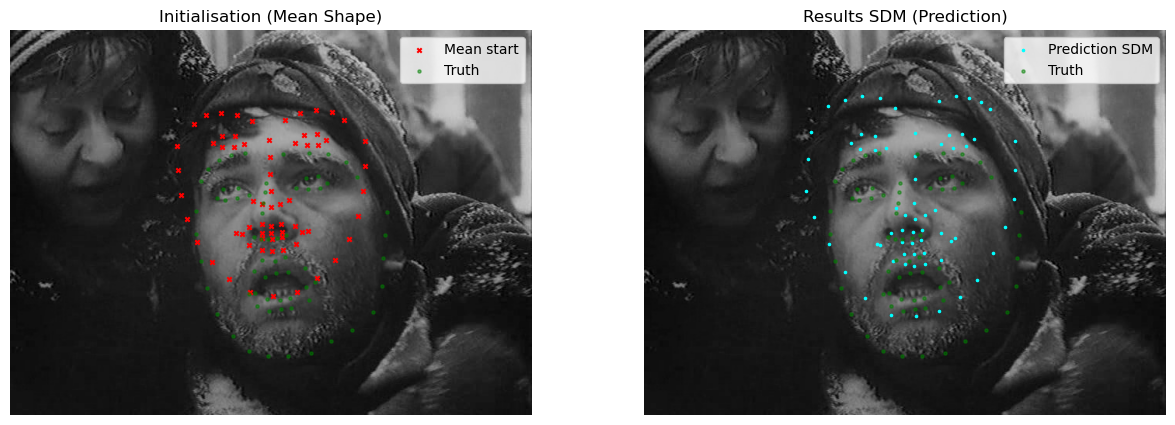

In [16]:
def visualize_result(sdm, image_obj):
    """
    Plot predictedd landmarks:
        Green is the true landmark (labels)
        Red is the mean face landmarks
        Blue is the predicted landmarks with SDM
    """
    # Predict new image
    predicted_image=sdm.predict(image_obj)
    predicted_landmark=predicted_image.current_landmark
    
    
    plt.figure(figsize=(15, 5))
    
    # Image before optimization
    plt.subplot(1, 2, 1)
    plt.title("Initialisation (Mean Shape)")
    if len(image_obj.image.shape) == 3:
        plt.imshow(cv2.cvtColor(image_obj.image, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(image_obj.image, cmap='gray')
        
    plt.scatter(image_obj.current_landmark[:, 0], image_obj.current_landmark[:, 1], 
                c='red', s=10, marker='x', label='Mean start')
    plt.scatter(image_obj.true_landmark[:, 0], image_obj.true_landmark[:, 1], 
                c='green', s=5, alpha=0.5, label='Truth')
    plt.legend()
    plt.axis('off')

    # Image after optimization
    plt.subplot(1, 2, 2)
    plt.title("Results SDM (Prediction)")
    if len(image_obj.image.shape) == 3:
        plt.imshow(cv2.cvtColor(image_obj.image, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(image_obj.image, cmap='gray')
    plt.scatter(predicted_landmark[:, 0], predicted_landmark[:, 1], 
                c='cyan', s=10, marker='.', label='Prediction SDM')
    plt.scatter(image_obj.true_landmark[:, 0], image_obj.true_landmark[:, 1], 
                c='green', s=5, alpha=0.5, label='Truth')
    plt.legend()
    plt.axis('off')
    
    plt.show()


for i in range(5):
    idx=random.randint(1,len(test_data))
    print(f"Test in image {idx}")
    visualize_result(sdm, test_data[idx])

### Test score

Évaluation sur 160 images...
Evaluation terminée. NME Moyen : 0.3011 (30.11%)
Score Global (NME) : 0.3011


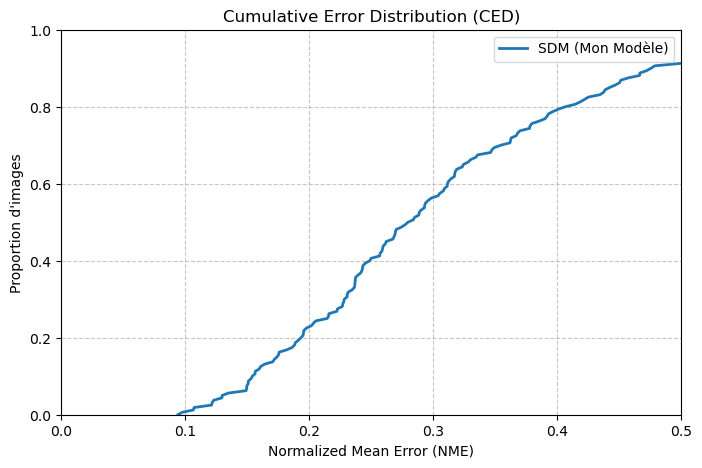

In [17]:
# 1. Calcul des scores
mean_nme, all_nmes = sdm.evaluate(test_data)

# 2. Affichage textuel
print(f"Score Global (NME) : {mean_nme:.4f}")


# 3. Traçage de la courbe CED
# La courbe montre le % d'images (Y) qui ont une erreur inférieure à X
sorted_errors = np.sort(all_nmes)
proportions = np.arange(len(sorted_errors)) / len(sorted_errors)

plt.figure(figsize=(8, 5))
plt.plot(sorted_errors, proportions, label='SDM (Mon Modèle)', linewidth=2)

# Esthétique du graphe
plt.title("Cumulative Error Distribution (CED)")
plt.xlabel("Normalized Mean Error (NME)")
plt.ylabel("Proportion d'images")
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.xlim(0, 0.5) # On zoome sur les erreurs entre 0 et 20%
plt.ylim(0, 1.0)
plt.legend()

plt.show()

### Error analysis

Get worst failures of the model, this is particularly useful to calibrate the model and fix issue.

Évaluation sur 160 images...
Evaluation terminée. NME Moyen : 0.3011 (30.11%)
--- Top 3 des Pires Échecs ---
Image Index 80 - Erreur NME: 0.6549


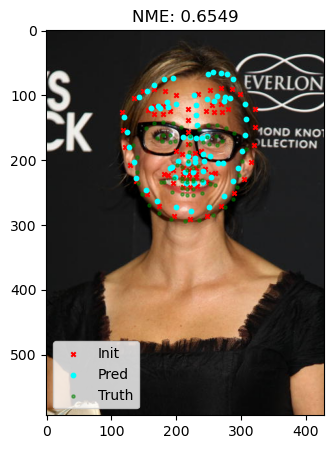

Image Index 151 - Erreur NME: 0.6401


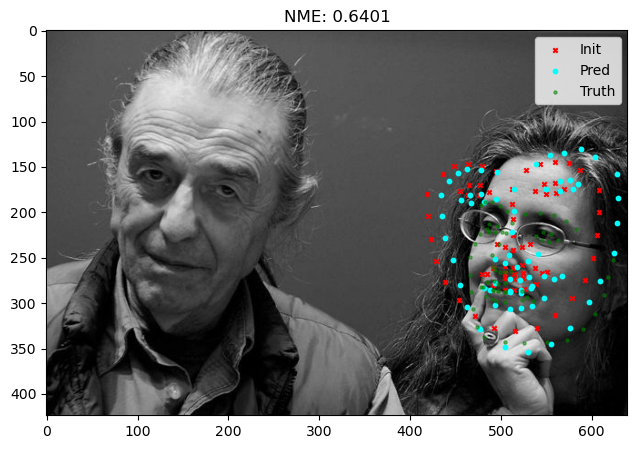

Image Index 61 - Erreur NME: 0.6072


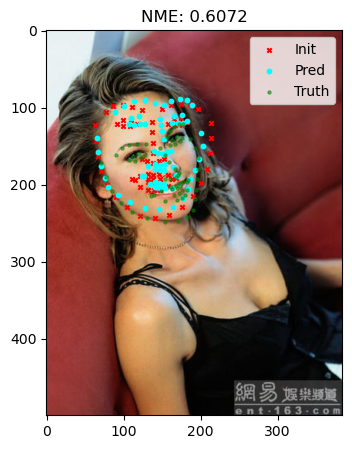

In [ ]:
def show_worst_failures(model, test_data, n=3):
    _, all_errors = model.evaluate(test_data)
    
    worst_indices = np.argsort(all_errors)[::-1][:n]
    
    print(f"Worst {n} failures")
    
    for idx in worst_indices:
        img_obj = test_data[idx]
        score = all_errors[idx]
        
        print(f"Image Index {idx} - Erreur NME: {score:.4f}")
        pred_img = model.predict(img_obj)
        
        plt.figure(figsize=(10, 5))
        if len(img_obj.image.shape) == 3:
            plt.imshow(cv2.cvtColor(img_obj.image, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(img_obj.image, cmap='gray')

        plt.scatter(img_obj.current_landmark[:, 0], img_obj.current_landmark[:, 1], 
                    c='red', s=10, marker='x', label='Init')
        plt.scatter(pred_img.current_landmark[:, 0], pred_img.current_landmark[:, 1], 
                    c='cyan', s=10, label='Pred')
        plt.scatter(img_obj.true_landmark[:, 0], img_obj.true_landmark[:, 1], 
                    c='green', s=5, alpha=0.5, label='Truth')
        
        plt.legend()
        plt.title(f"NME: {score:.4f}")
        plt.show()

show_worst_failures(sdm, test_data)

In [7]:
def evaluate_in_pixels(model, test_data):
    """
    Calcule l'erreur moyenne en pixels (Euclidean Distance).
    C'est beaucoup plus parlant pour le debugging.
    """
    total_pixel_error = 0
    total_points = 0
    max_error = 0
    worst_image_idx = -1
    
    print(f"Calcul des erreurs en pixels sur {len(test_data)} images...")
    
    errors_per_image = []

    for idx, img_obj in enumerate(test_data):
        # Prédiction
        pred_img = model.predict(img_obj)
        
        # Récupération des points
        pred_lm = pred_img.current_landmark
        true_lm = img_obj.true_landmark
        
        # Calcul de la distance Euclidienne pour chaque point : sqrt((x1-x2)^2 + (y1-y2)^2)
        # axis=1 signifie qu'on calcule la norme pour chaque ligne (chaque point)
        diff_vectors = pred_lm - true_lm
        distances = np.linalg.norm(diff_vectors, axis=1)
        
        # Stats pour cette image
        mean_img_error = np.mean(distances)
        max_img_error = np.max(distances)
        
        errors_per_image.append(mean_img_error)
        
        # Mise à jour des stats globales
        total_pixel_error += np.sum(distances)
        total_points += len(distances)
        
        # Tracking du pire cas
        if mean_img_error > max_error:
            max_error = mean_img_error
            worst_image_idx = idx

    global_mean_pixel_error = total_pixel_error / total_points
    
    print(f"\n--- RÉSULTATS EN PIXELS ---")
    print(f"Erreur Moyenne Globale : {global_mean_pixel_error:.2f} pixels")
    print(f"Pire Erreur Moyenne sur une image : {max_error:.2f} pixels")
    print(f"Index de la pire image : {worst_image_idx}")
    
    return global_mean_pixel_error, errors_per_image, worst_image_idx

def visualize_error_vectors(model, test_data, image_indices=None):
    """
    Affiche les vecteurs d'erreur : Trait reliant Prédiction -> Vérité.
    Permet de voir la DIRECTION systématique de l'erreur.
    """
    if image_indices is None:
        # Par défaut, on prend 3 images au hasard
        image_indices = np.random.choice(len(test_data), 3, replace=False)
        
    for idx in image_indices:
        img_obj = test_data[idx]
        pred_img = model.predict(img_obj)
        
        pred_lm = pred_img.current_landmark.astype(int)
        true_lm = img_obj.true_landmark.astype(int)
        
        # On copie l'image pour dessiner dessus
        # Conversion RGB pour matplotlib
        if len(img_obj.image.shape) == 3:
            canvas = cv2.cvtColor(img_obj.image.copy(), cv2.COLOR_BGR2RGB)
        else:
            canvas = cv2.cvtColor(img_obj.image.copy(), cv2.COLOR_GRAY2RGB)
            
        # Calcul de l'erreur moyenne pour le titre
        diff = np.linalg.norm(pred_lm - true_lm, axis=1)
        err_px = np.mean(diff)

        # DESSIN DES VECTEURS
        for i in range(len(pred_lm)):
            pt_pred = tuple(pred_lm[i])
            pt_true = tuple(true_lm[i])
            
            # 1. Trait ROSE : Relie la prédiction à la vérité
            # Cela montre "Le chemin qu'il aurait fallu parcourir"
            cv2.line(canvas, pt_pred, pt_true, (255, 0, 255), 1) 
            
            # 2. Points
            cv2.circle(canvas, pt_pred, 2, (0, 255, 255), -1) # Cyan = Pred
            cv2.circle(canvas, pt_true, 2, (0, 255, 0), -1)   # Vert = Vérité

        plt.figure(figsize=(8, 8))
        plt.imshow(canvas)
        plt.title(f"Image {idx} - Erreur Moyenne: {err_px:.1f} px\nTraits Roses = Erreur de déplacement")
        plt.axis('off')
        plt.legend(['Erreur', 'Pred (Cyan)', 'Vrai (Vert)']) # Légende indicative
        plt.show()

Calcul des erreurs en pixels sur 160 images...

--- RÉSULTATS EN PIXELS ---
Erreur Moyenne Globale : 21.12 pixels
Pire Erreur Moyenne sur une image : 62.82 pixels
Index de la pire image : 25
Visualisation de la pire image :


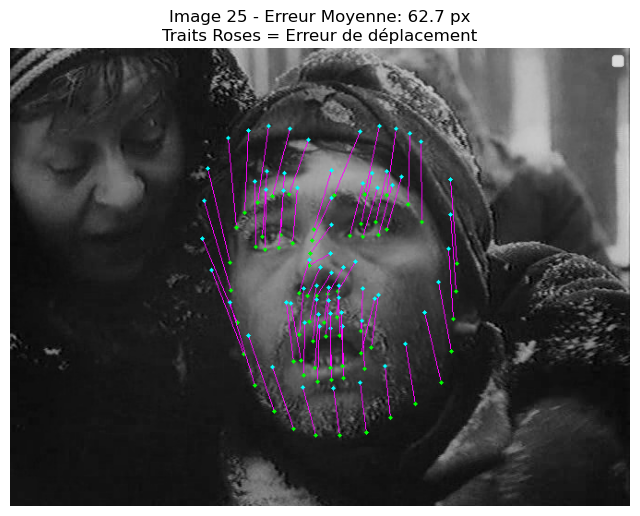

Visualisation aléatoire :


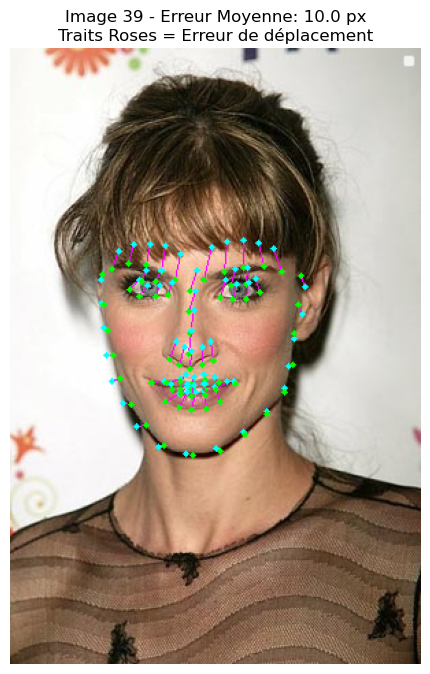

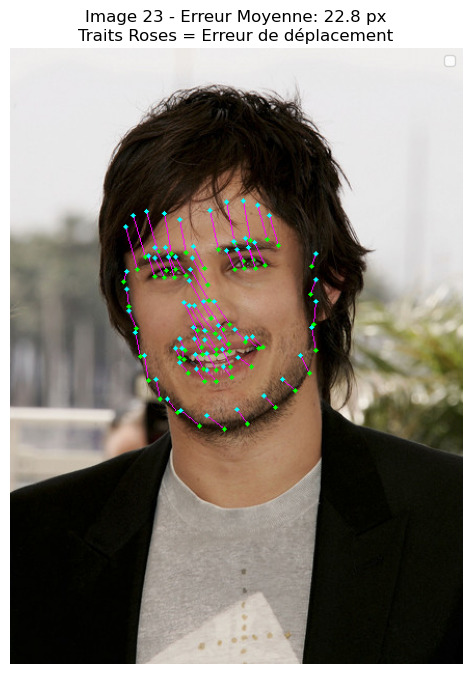

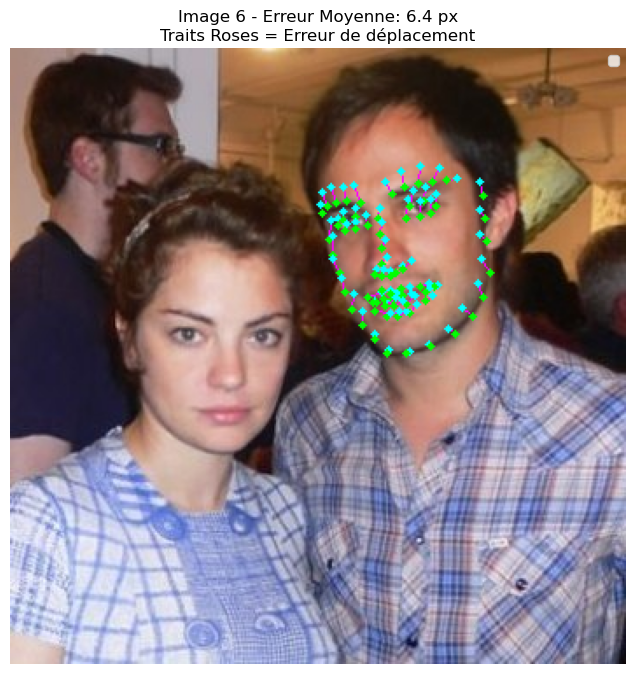

In [8]:
# 1. Avoir les chiffres
mean_px, errors, worst_idx = evaluate_in_pixels(sdm, test_data)

# 2. Voir les vecteurs sur la pire image
print("Visualisation de la pire image :")
visualize_error_vectors(sdm, test_data, image_indices=[worst_idx])

# 3. Voir les vecteurs sur quelques images aléatoires
print("Visualisation aléatoire :")
visualize_error_vectors(sdm, test_data)